In [1]:
%matplotlib inline
import os 
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
from rasterio import features
from affine import Affine
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from scipy.stats import t, norm, ttest_1samp
import xesmf as xe
from time import time
import warnings
from statsmodels.distributions.empirical_distribution import ECDF
from random import choices
from sklearn.neighbors import KernelDensity

warnings.filterwarnings('ignore')


In [2]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xarray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))

def get_dowy(date):
    try:
        date = pd.to_datetime(date)
    except:
        return np.nan
    if date.month >= 10:
        return date.dayofyear - pd.to_datetime(f"{date.year}-10-01").dayofyear + 1
    else: 
        return date.dayofyear + 92

In [3]:
root_dir = "/dartfs-hpc/rc/lab/C/CMIG"
data_dir = os.path.join(root_dir, "agottlieb", "snow_drought", "data")
fig_dir = os.path.join(root_dir, "agottlieb", "snow_drought", "figures")

In [6]:
grdc_basins = gpd.read_file(os.path.join(data_dir, "etc", "grdc_basins"), layer="mrb_basins")
basin_ids = {k: i for i, k in enumerate(grdc_basins.RIVER_BASI)}
basin_shapes = [(shape, n) for n, shape in enumerate(grdc_basins.geometry)]

In [7]:
# load basin-scale ensemble w/ peak and April 1 SWE
basin_swe_ensemble = pd.read_csv(os.path.join(data_dir,"ensembles","basin_peak_ensemble.csv"))
basin_swe_ensemble["time"] = pd.to_datetime(basin_swe_ensemble["time"].values)
basin_swe_ensemble = xr.Dataset.from_dataframe(basin_swe_ensemble.set_index(["product","time","basin"]))
basin_swe_ensemble = basin_swe_ensemble.sel(time=slice("2002-10-01", "2017-10-01"))

# calculate anomalies
basin_swe_ensemble["peak_swe_anom"] = (basin_swe_ensemble["peak_swe"]-basin_swe_ensemble["peak_swe"].mean("time")) / basin_swe_ensemble["peak_swe"].std("time")
basin_swe_ensemble["apr1_swe_anom"] = (basin_swe_ensemble["apr1_swe"]-basin_swe_ensemble["apr1_swe"].mean("time")) / basin_swe_ensemble["apr1_swe"].std("time")
basin_swe_ensemble["peak_date_anom"] = (basin_swe_ensemble["peak_date"]-basin_swe_ensemble["peak_date"].mean("time")) / basin_swe_ensemble["peak_date"].std("time")

# load basin-scale ensemble w/ SWEI
basin_swei_ensemble = pd.read_csv(os.path.join(data_dir,"ensembles","basin_swei_ensemble.csv"))
basin_swei_ensemble["time"] = pd.to_datetime(basin_swei_ensemble["time"].values)
basin_swei_ensemble = xr.Dataset.from_dataframe(basin_swei_ensemble.set_index(["product","time","basin"]))

# take min MAM SWEI and cumulative MAM SWE deficit and add to first ensemble
basin_swei_ensemble = basin_swei_ensemble.where((basin_swei_ensemble["time.month"]>=3)&(basin_swei_ensemble["time.month"]<=5))
basin_swe_ensemble["swei"] = basin_swei_ensemble["swei"].resample(time="AS-OCT").min().sel(time=slice("2002-10-01","2017-10-01"))
basin_swe_ensemble["swe_deficit"] = basin_swei_ensemble["SNOMAS_diff_clim"].resample(time="AS-OCT").sum(min_count=1).sel(time=slice("2002-10-01","2017-10-01"))

basin_swei_ensemble.close()

In [8]:
# rasterize basins onto 0.5 degree grid, merge with SWE ensemble
res = 0.5
coords = {"lat": np.arange(-90+res/2, 90+res/2, res)[::-1],
          "lon": np.arange(-180+res/2, 180+res/2, res)}
basin_grid = rasterize(basin_shapes, coords=coords)
basin_grid.name="basin"
basin_grid_df = basin_grid.to_dataframe().reset_index()
basin_grid_df.dropna(subset=["basin"],inplace=True)
basin_swe_ensemble_df = basin_swe_ensemble.to_dataframe().reset_index()
basin_swe_ensemble_df = basin_swe_ensemble_df.merge(basin_grid_df,on="basin")
basin_swe_ensemble = xr.Dataset.from_dataframe(basin_swe_ensemble_df.set_index(["product","time","lat","lon"]))

In [10]:
# soil moisture data from Williams et al. (2020)
sm_data = xr.open_dataset(os.path.join(data_dir,"etc","SMfz_EnsembleMean.nc"))
sm_data["time"] = [pd.to_datetime(f"{int(y-1)}-10-01") for y in sm_data["time"].values] # assign JJA value to WY
basin_swe_ensemble = xr.merge([basin_swe_ensemble, sm_data],join="inner")

In [26]:
usdm_droughts = xr.open_dataset(os.path.join(data_dir,"etc","usdm_droughts.nc"))

In [27]:
usdm_droughts["usdm_drought"] =usdm_droughts["drought_class"]>=1
sm_data["sm_drought"] = sm_data["SMfz"] < -1

all_droughts = xr.merge([usdm_droughts["usdm_drought"],sm_data["sm_drought"]],join="inner")
all_droughts = all_droughts.where(~xr.ufuncs.isnan(sm_data["SMfz"]))

In [28]:
all_droughts["both"] = (all_droughts["usdm_drought"]==True) & (all_droughts["sm_drought"]==True)
all_droughts["either"] = (all_droughts["usdm_drought"]==True) | (all_droughts["sm_drought"]==True)

In [29]:
from sklearn.metrics import cohen_kappa_score
kappas = xr.apply_ufunc(cohen_kappa_score,all_droughts["usdm_drought"].fillna(-1),all_droughts["sm_drought"].fillna(-1),input_core_dims=[["time"],["time"]],vectorize=True).to_dataset(name="cohen_kappa")
kappas["basin"] = basin_peak_ensemble["basin"].mean('time').mean('product')

In [30]:
frac_shared = (all_droughts["both"].sum("time")/all_droughts["either"].sum("time"))
frac_shared["basin"] = basin_peak_ensemble["basin"].mean("time").mean("product")

Text(0.5, 0, '$\\frac{WSD_{USDM}\\cap WSD_{SM}}{WSD_{USDM}\\cup WSD_{SM}}$')

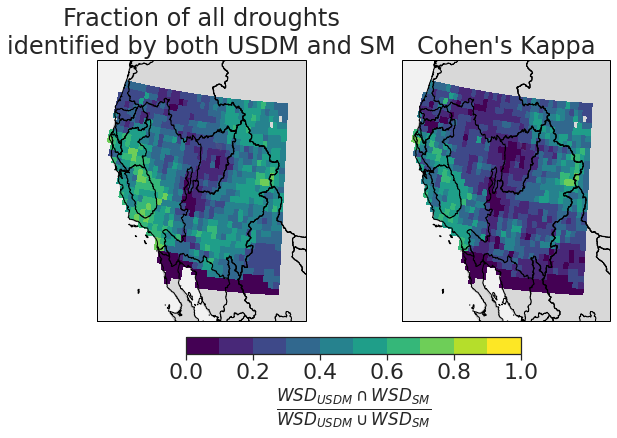

In [31]:
sns.set(style="ticks", font_scale=2)
mpl.rcParams['hatch.linewidth'] = 2.0
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)

agree_cmap = plt.cm.get_cmap("viridis",10)
agree_norm = plt.Normalize(vmin=0,vmax=1)
ax1 = plt.subplot(gs[0], projection=ccrs.AlbersEqualArea(central_latitude=45,central_longitude=-100))
(all_droughts["both"].sum("time")/all_droughts["either"].sum("time")).plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=agree_cmap, norm=agree_norm,add_colorbar=False)

shape_feature = ShapelyFeature(Reader(os.path.join(data_dir,"etc","us_basins_parkdata")).geometries(),
                                ccrs.PlateCarree(), facecolor='none',edgecolor="black")
ax1.add_feature(shape_feature)
ax1.set_extent([-122,-103,28,47], ccrs.PlateCarree())
ax1.coastlines('10m')
ax1.add_feature(cartopy.feature.LAND, facecolor="grey",alpha=0.3)
# ax1.add_feature(cartopy.feature.BORDERS)
ax1.add_feature(cartopy.feature.OCEAN,facecolor="grey",alpha=0.1)
ax1.add_feature(cartopy.feature.LAKES,facecolor="grey",alpha=0.1)
# ax1.add_feature(states_provinces, edgecolor='black')
# ax1.set_aspect("auto")
ax1.title.set_text("Fraction of all droughts\nidentified by both USDM and SM")

ax2 = plt.subplot(gs[1], projection=ccrs.AlbersEqualArea(central_latitude=45,central_longitude=-100))
kappas["cohen_kappa"].plot(ax=ax2, transform=ccrs.PlateCarree(), cmap=agree_cmap, norm=agree_norm,add_colorbar=False)

shape_feature = ShapelyFeature(Reader(os.path.join(data_dir,"etc","us_basins_parkdata")).geometries(),
                                ccrs.PlateCarree(), facecolor='none',edgecolor="black")
ax2.add_feature(shape_feature)
ax2.set_extent([-122,-103,28,47], ccrs.PlateCarree())
ax2.coastlines('10m')
ax2.add_feature(cartopy.feature.LAND, facecolor="grey",alpha=0.3)
# ax1.add_feature(cartopy.feature.BORDERS)
ax2.add_feature(cartopy.feature.OCEAN,facecolor="grey",alpha=0.1)
ax2.add_feature(cartopy.feature.LAKES,facecolor="grey",alpha=0.1)
# ax1.add_feature(states_provinces, edgecolor='black')
# ax1.set_aspect("auto")
ax2.title.set_text("Cohen's Kappa")


sm = plt.cm.ScalarMappable(cmap=agree_cmap,norm=agree_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax1,ax2], orientation="horizontal",shrink=0.6,pad=0.05,use_gridspec=True)
cbar.ax.set_xlabel(r"$\frac{WSD_{USDM}\cap WSD_{SM}}{WSD_{USDM}\cup WSD_{SM}}$")
# plt.savefig(os.path.join(fig_dir,"drought_agree_sd0.5.png"))
# plt.savefig(os.path.join(fig_dir,"us_sm_drought_pdiff_parkdata.png"),transparent=True)


In [32]:
all_droughts["basin"] = basin_peak_ensemble["basin"]

### Definitions
- Hatchett & McEvoy (2017): < clim. SWE (continuous)
- Huning & AghaKouchak (2020): SWEI < -0.8 (continuous)
- Harpold et al. (2017): < clim. Apr. 1 SWE 
- Marshall et al. (2019): < 25th %ile peak SWE
- Dierauer et al. (2019): < clim. peak SWE

In [33]:
def robustness(comp1,comp2):
    comp1_vals = comp1.flatten()
    comp1_vals = comp1_vals[~np.isnan(comp1_vals)]
    if len(comp1_vals)==0:
        return np.nan
    comp2_vals = comp2.flatten()
    comp2_vals = comp2_vals[~np.isnan(comp2_vals)]
    if len(comp2_vals)==0:
        return np.nan
    comp1_ecdf = ECDF(comp1_vals)
    xs = comp1_ecdf.x
    comp1_cdf_obs = comp1_ecdf.y
    
    m1 = np.nanmean(np.nanmean(comp1,axis=1))
    s1 = np.nanstd(np.nanmean(comp1,axis=1))
    comp1_cdf_est = norm.cdf(xs,m1,s1)
    
    comp1_obs_est_diff = (comp1_cdf_est-comp1_cdf_obs)**2
    a1 = np.trapz(comp1_obs_est_diff)
    
    m2 = np.nanmean(np.nanmean(comp2,axis=1))
    s2 = np.nanstd(np.nanmean(comp2,axis=1))
    comp2_cdf_est = norm.cdf(xs,m2,s2)   
    comp2_cdf_est = np.nan_to_num(comp2_cdf_est,nan=1)
    
    est_cdf_diff = (comp2_cdf_est-comp1_cdf_est)**2
    a2 = np.trapz(est_cdf_diff)
    
    return 1-a1/a2

In [11]:
# Huning & AghaKouchak (2020): SWEI < -0.8 (continuous)
sd_ha20 = (basin_swe_ensemble["swei"] < -0.8).astype(float).where(~xr.ufuncs.isnan(basin_swe_ensemble["swei"]))
sd_ha20.name = "snow_drought"
sd_ha20 = sd_ha20.assign_coords(definition="ha20")

# Harpold et al. (2017): < clim. Apr. 1 SWE 
sd_h17 = (basin_swe_ensemble["apr1_swe_anom"] < 0).astype(float).where(~xr.ufuncs.isnan(basin_swe_ensemble["apr1_swe_anom"]))
sd_h17.name = "snow_drought"
sd_h17 = sd_h17.assign_coords(definition="h17")

# Marshall et al. (2019): < 25th %ile peak SWE
sd_m19_low = (basin_swe_ensemble["peak_swe_anom"]<norm.ppf(0.25)).astype(float).where(~xr.ufuncs.isnan(basin_swe_ensemble["peak_swe_anom"]))
sd_m19_low.name = "snow_drought"
sd_m19_low = sd_m19_low.assign_coords(definition="m19_low")

# Marshall et al. (2019): < 25th %ile peak SWE date
sd_m19_early = (basin_swe_ensemble["peak_date_anom"]<norm.ppf(0.25)).astype(float).where(~xr.ufuncs.isnan(basin_swe_ensemble["peak_date_anom"]))
sd_m19_early.name = "snow_drought"
sd_m19_early = sd_m19_early.assign_coords(definition="m19_early")

# Dierauer et al. (2019): < clim. peak SWE
sd_d19 = (basin_swe_ensemble["peak_swe_anom"]<0).astype(float).where(~xr.ufuncs.isnan(basin_swe_ensemble["peak_swe_anom"]))
sd_d19.name="snow_drought"
sd_d19 = sd_d19.assign_coords(definition="d19")

# Hatchett & McEvoy (2017): < clim. SWE (continuous)
sd_hm17 = (basin_swe_ensemble["swe_deficit"]<0).astype(float).where(~xr.ufuncs.isnan(basin_swe_ensemble["swe_deficit"]))
sd_hm17.name="snow_drought"
sd_hm17 = sd_d19.assign_coords(definition="hm17")

# combine all definitions 
def_ds = xr.concat([sd_ha20, sd_h17, sd_m19_low, sd_m19_early, sd_d19, sd_hm17],dim="definition")

# merge snow drought and USDM datasets
def_ds = xr.merge([def_ds,sm_data])
def_ds = def_ds.stack(data_def=("definition","product")) # make data-definition combos single dimension
def_ds = def_ds.sel(lon=slice(-125,-70),lat=slice(25,51)) # clip to US

In [21]:
# composite on SM anomalies < -1sigma
wsd_sm = def_ds.where(def_ds["SMfz"]<-1)
no_wsd_sm =  def_ds.where(def_ds["SMfz"]>=-1)

# proportion of years w/ and w/o WSD season drought preceded by snow drought (across all data-definition combos)
p_sd_wsd_sm = wsd_sm["snow_drought"].mean("data_def").mean("time")
p_sd_wsd_sm_c = no_wsd_sm["snow_drought"].mean("data_def").mean("time")

In [18]:
OVERWRITE = False

In [ ]:
# take 1000 bootstrap samples across all data-definition combos
if not os.path.exists(os.path.join(data_dir,"etc","p_sd_wsd_bootstrap_parkdata.nc")) or OVERWRITE:
    n_bootstrap = 1000
    n = len(def_ds["data_def"])
    wsd_bootstrap_data = []
    no_wsd_bootstrap_data = []
    t0 = time()
    for i in range(n_bootstrap):
        bootstrap_ind = choices(range(n), k=n) # sample data-definition combos w/ replacement
        bs = def_ds.isel(data_def=bootstrap_ind)
        wsd_bs = bs.where(bs["SMfz"]<-1).mean("data_def").mean("time") # WSD composite
        no_wsd_bs = bs.where(bs["SMfz"]>=-1).mean("data_def").mean("time") # no WSD composite
        wsd_bs = wsd_bs.assign_coords(b=i)
        no_wsd_bs = no_wsd_bs.assign_coords(b=i)

        wsd_bootstrap_data.append(wsd_bs)
        no_wsd_bootstrap_data.append(no_wsd_bs)
        if i >= 50 and i % 50 == 0:
            t1=time()
            print(i,t1-t0)
            t0 = t1
            
    # combine all bootstrap samples into one DataSet
    bs_wsd = xr.concat(wsd_bootstrap_data,dim="b")
    bs_no_wsd = xr.concat(no_wsd_bootstrap_data,dim="b")
    
    # get deviations of bootstrap samples from sample mean
    bs_wsd_diff = bs_wsd["snow_drought"]-p_sd_wsd_sm
    bs_no_wsd_diff = bs_no_wsd["snow_drought"]-p_sd_wsd_sm_c
    
    # CI = sample mean +/- 2.5/97.5th percentile of bootstrap deviations from sample mean
    bs_wsd_ci = p_sd_wsd_sm - bs_wsd_diff.quantile([0.025,0.975],dim="b")
    bs_no_wsd_ci = p_sd_wsd_sm_c - bs_no_wsd_diff.quantile([0.025,0.975],dim="b")
    
    bs_wsd_ci.to_netcdf(os.path.join(data_dir,"etc","p_sd_wsd_bootstrap_parkdata.nc"))
    bs_no_wsd_ci.to_netcdf(os.path.join(data_dir,"etc","p_sd_no_wsd_bootstrap_parkdata.nc"))

In [23]:
bs_wsd_diff = bs_wsd["snow_drought"]-p_sd_wsd_sm
bs_no_wsd_diff = bs_no_wsd["snow_drought"]-p_sd_wsd_sm_c

# CI = sample mean +/- 2.5/97.5th percentile of bootstrap deviations from sample mean
bs_wsd_ci = p_sd_wsd_sm - bs_wsd_diff.quantile([0.025,0.975],dim="b")
bs_no_wsd_ci = p_sd_wsd_sm_c - bs_no_wsd_diff.quantile([0.025,0.975],dim="b")

bs_wsd_ci.to_netcdf(os.path.join(data_dir,"etc","p_sd_wsd_bootstrap_parkdata.nc"))
bs_no_wsd_ci.to_netcdf(os.path.join(data_dir,"etc","p_sd_no_wsd_bootstrap_parkdata.nc"))

In [24]:
# determine if 95% confidence intervals overlap
bs_wsd_ci = xr.open_dataset(os.path.join(data_dir,"etc","p_sd_wsd_bootstrap_parkdata.nc"))
bs_no_wsd_ci = xr.open_dataset(os.path.join(data_dir,"etc","p_sd_no_wsd_bootstrap_parkdata.nc"))
ci_overlap = bs_wsd_ci.isel(quantile=1) <= bs_no_wsd_ci.isel(quantile=0)
ci_overlap = ci_overlap.astype(float)

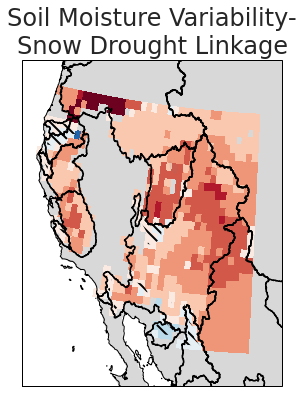

In [38]:
sns.set(style="ticks", font_scale=2)
mpl.rcParams['hatch.linewidth'] = 2.0
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(ncols=1,nrows=1,figure=fig)

# colormap for difference in conditional probabilities
diff_cmap = plt.cm.get_cmap("RdBu_r")
diff_colors = [diff_cmap(i) for i in np.linspace(0.1,0.9,10)]
diff_cmap = mpl.colors.ListedColormap(diff_colors,name="diff")
diff_cmap.set_under(plt.cm.get_cmap("RdBu_r")(0))
diff_cmap.set_over(plt.cm.get_cmap("RdBu_r")(0.99))
diff_norm = plt.Normalize(vmin=-0.5,vmax=0.5)
            
ax1 = plt.subplot(gs[0], projection=ccrs.AlbersEqualArea(central_latitude=45,central_longitude=-100))
da = (p_sd_wsd_sm-p_sd_wsd_sm_c) # difference in conditional probabilities
da.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=diff_cmap, norm=diff_norm, add_colorbar=False)
asp = ax1.get_aspect() # preserve aspect ratio b/c plotting basin boundaries distorts
ci_overlap["snow_drought"].plot.contourf(ax=ax1,transform=ccrs.PlateCarree(), colors="none",levels=[0,0.99,2],hatches=[None,"\\\\"],add_colorbar=False) # hatch where CIs overlap

# plot basin boundaries on map
us_basins = np.unique(basin_swe_ensemble["basin"].where(~xr.ufuncs.isnan(basin_swe_ensemble["SMfz"].max("time"))))
us_basins = us_basins[~np.isnan(us_basins)]
grdc_basins.loc[us_basins].geometry.boundary.plot(ax=ax1,transform=ccrs.PlateCarree(),color="black")

ax1.set_aspect(asp)
ax1.set_extent([-122,-103,28,47], ccrs.PlateCarree())
ax1.coastlines('10m')
ax1.add_feature(cartopy.feature.LAND, facecolor="grey",alpha=0.3)
ax1.add_feature(cartopy.feature.OCEAN,facecolor="white")
ax1.add_feature(cartopy.feature.LAKES,facecolor="grey",alpha=0.1)

ax1.title.set_text("Soil Moisture Variability-\nSnow Drought Linkage")
plt.savefig(os.path.join(fig_dir,"fig3_inset.png"),bbox_inches="tight",transparent=True) # make transparent for adding to main plot